In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

# load mosaic data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [ ]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [ ]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [ ]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



In [ ]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [ ]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [ ]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [ ]:
val_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_val =[]                   #list of indexes at which foreground image is present in a mosaic image                
val_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+40000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_val.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  val_images.append(image_list)
  val_label.append(label)

In [ ]:
val_data = MosaicDataset(val_images,val_label,fore_idx_val)
val_loader = DataLoader( val_data,batch_size= batch ,shuffle=False)

# models

In [ ]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [ ]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [ ]:
torch.manual_seed(1234)
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)
torch.manual_seed(1234)
what_net = Module2().double()
what_net = what_net.to("cuda")

In [ ]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis,correct.item(),tot,correct.item()/tot

In [ ]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

# training

In [17]:
# instantiate optimizer
optimizer_where = optim.RMSprop(where_net.parameters(),lr =0.0009)#,nesterov=True)
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.0009)#,nesterov=True)
 

scheduler_where = optim.lr_scheduler.ReduceLROnPlateau(optimizer_where, mode='min', factor=0.5, patience=2,min_lr=5e-5,verbose=True)
scheduler_what = optim.lr_scheduler.ReduceLROnPlateau(optimizer_what, mode='min', factor=0.5, patience=2,min_lr=5e-5, verbose=True)


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 120

every_what_epoch = 20

# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,where_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)



running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(test_loader,what_net,where_net,criterion)
print('test epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 

loss_curi_tst.append(running_loss)
analysis_data_tst.append(anlys_data)

running_loss_val,anlys_data,correct,total,accuracy = calculate_attn_loss(val_loader,what_net,where_net,criterion)
print('validation epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_val,correct,total,accuracy))



# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  where_net.train()
  if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
    print(epoch+1,"updating what_net, where_net is freezed")
    print("--"*40)
  elif ((epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
    print(epoch+1,"updating where_net, what_net is freezed")
    print("--"*40)
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_ = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"),labels.to("cuda")
        
    # zero the parameter gradients
    optimizer_where.zero_grad()
    optimizer_what.zero_grad()
      
    # forward + backward + optimize
    avg, alpha = where_net(inputs)
    outputs = what_net(avg)
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    loss.backward()
    if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
      optimizer_what.step()
    elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
      optimizer_where.step()
  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,where_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  # calculate loss for test data
  running_loss_tst,anls_data,correct,total,accuracy = calculate_attn_loss(test_loader,what_net,where_net,criterion)
  analysis_data_tst.append(anls_data)
  loss_curi_tst.append(running_loss_tst)   #loss per epoch
  print('test epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tst,correct,total,accuracy)) 

  # calculate loss for validation data
  running_loss_val,anls_data,correct,total,accuracy = calculate_attn_loss(val_loader,what_net,where_net,criterion)
  print('validation epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_val,correct,total,accuracy)) 
  
  if running_loss_tr<=0.05:
    break
  if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
    scheduler_what.step(running_loss_val)
  elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
    scheduler_where.step(running_loss_val)
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)
analysis_data_tst = np.array(analysis_data_tst)    

training epoch: [0 ] loss: 1.121 correct: 10013.000, total: 30000.000, accuracy: 0.334
test epoch: [0 ] loss: 1.139 correct: 3304.000, total: 10000.000, accuracy: 0.330
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
training epoch: [1 ] loss: 1.087 correct: 12138.000, total: 30000.000, accuracy: 0.405
test epoch: [1 ] loss: 1.108 correct: 4000.000, total: 10000.000, accuracy: 0.400
validation epoch: [1 ] loss: 1.109 correct: 3985.000, total: 10000.000, accuracy: 0.399
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
training epoch: [2 ] loss: 1.068 correct: 13303.000, total: 30000.000, accuracy: 0.443
test epoch: [2 ] loss: 1.090 correct: 4395.000, total: 10000.000, accuracy: 0.440
validation epoch: [2 ] loss: 1.093 correct: 4308.000, total: 10000.000, accuracy: 0.431
3 updating what_net, where_net is freezed
-----------------------------

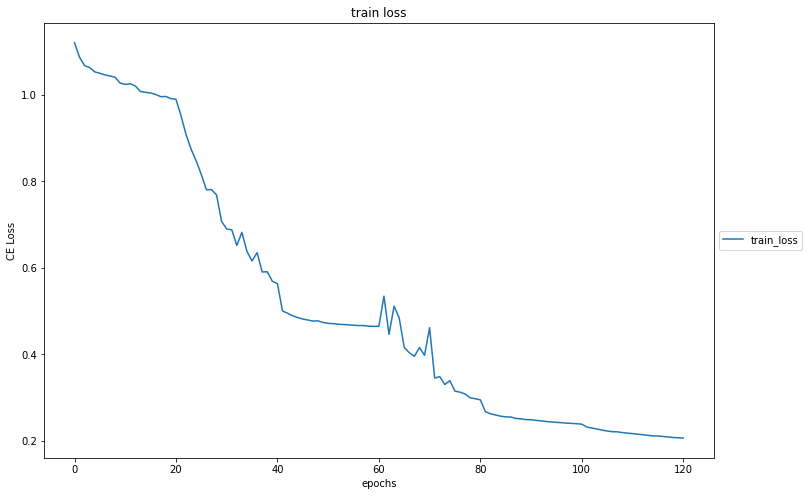

In [33]:
fig = plt.figure(figsize = (12,8)) 
vline_list = np.arange(every_what_epoch, epoch + every_what_epoch, every_what_epoch)
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(0, epoch+2)
plt.plot(epoch_list,loss_curi_tr, label='train_loss')
#plt.plot(epoch_list,loss_curi_tst, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
#plt.vlines(vline_list,min(min(loss_curi_tr),min(loss_curi_tst)), max(max(loss_curi_tst),max(loss_curi_tr)),linestyles='dotted')
plt.title("train loss")
plt.show()
fig.savefig("train_loss_every_20_plot.pdf")
fig.savefig("train_loss_every_20_plot.png")

In [34]:
analysis_data_tr

array([[ 2468,  7545,  3753, 16234,     0, 30000],
       [ 2776,  9362,  3445, 14417,     0, 30000],
       [ 2903, 10400,  3318, 13379,     0, 30000],
       [ 2651, 10792,  3570, 12987,     0, 30000],
       [ 2869, 10847,  3352, 12932,     0, 30000],
       [ 2881, 10947,  3340, 12832,     0, 30000],
       [ 2844, 11164,  3377, 12615,     0, 30000],
       [ 2934, 11031,  3287, 12748,     0, 30000],
       [ 2916, 11125,  3305, 12654,     0, 30000],
       [ 3071, 11512,  3150, 12267,     0, 30000],
       [ 2968, 11717,  3253, 12062,     0, 30000],
       [ 3089, 11432,  3132, 12347,     0, 30000],
       [ 3111, 11646,  3110, 12133,     0, 30000],
       [ 3113, 12113,  3108, 11666,     0, 30000],
       [ 3176, 11999,  3045, 11780,     0, 30000],
       [ 3178, 12035,  3043, 11744,     0, 30000],
       [ 3219, 12063,  3002, 11716,     0, 30000],
       [ 3179, 12261,  3042, 11518,     0, 30000],
       [ 3108, 12355,  3113, 11424,     0, 30000],
       [ 3251, 12328,  2970, 11

In [35]:
analysis_data_tr = np.array(analysis_data_tr)
analysis_data_tst = np.array(analysis_data_tst) 

In [36]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]
df_train[columns[2]] = analysis_data_tr[:,-1]
df_train[columns[3]] = analysis_data_tr[:,0]
df_train[columns[4]] = analysis_data_tr[:,1]
df_train[columns[5]] = analysis_data_tr[:,2]
df_train[columns[6]] = analysis_data_tr[:,3]

df_test[columns[0]] = np.arange(0,epoch+2)
df_test[columns[1]] = analysis_data_tst[:,-2]
df_test[columns[2]] = analysis_data_tst[:,-1]
df_test[columns[3]] = analysis_data_tst[:,0]
df_test[columns[4]] = analysis_data_tst[:,1]
df_test[columns[5]] = analysis_data_tst[:,2]
df_test[columns[6]] = analysis_data_tst[:,3]

In [37]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,30000,2468,7545,3753,16234
1,1,0,30000,2776,9362,3445,14417
2,2,0,30000,2903,10400,3318,13379
3,3,0,30000,2651,10792,3570,12987
4,4,0,30000,2869,10847,3352,12932
...,...,...,...,...,...,...,...
116,116,17069,12931,19451,8535,337,1677
117,117,17186,12814,19495,8480,355,1670
118,118,17161,12839,19476,8533,351,1640
119,119,17126,12874,19491,8531,344,1634


In [38]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,10000,791,2513,1172,5524
1,1,0,10000,858,3142,1105,4895
2,2,0,10000,918,3477,1045,4560
3,3,0,10000,841,3683,1122,4354
4,4,0,10000,891,3706,1072,4331
...,...,...,...,...,...,...,...
116,116,5466,4534,5742,1984,438,1836
117,117,5492,4508,5753,1966,446,1835
118,118,5505,4495,5739,1985,438,1838
119,119,5463,4537,5746,1981,428,1845


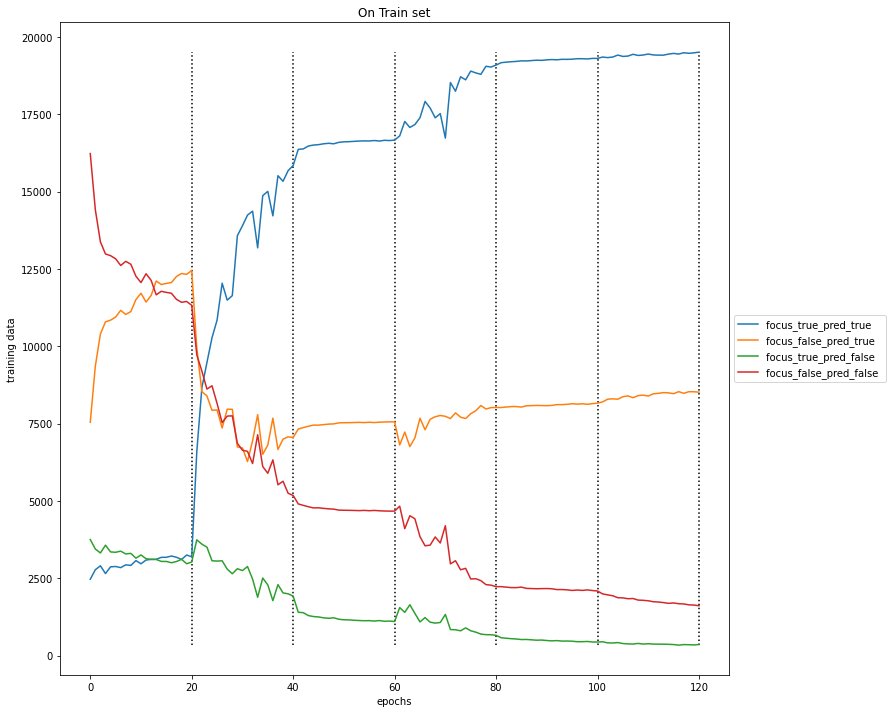

In [39]:
# plt.figure(figsize=(12,12))
# plt.plot(df_train[columns[0]],df_train[columns[1]], label='argmax > 0.5')
# plt.plot(df_train[columns[0]],df_train[columns[2]], label='argmax < 0.5')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("epochs")
# plt.ylabel("training data")
# plt.title("On Training set")
# #plt.vlines(vline_list,min(min(df_train[columns[1]]),min(df_train[columns[2]])), max(max(df_train[columns[1]]),max(df_train[columns[2]])),linestyles='dotted')
# plt.show()

plt.figure(figsize=(12,12))
plt.plot(df_train[columns[0]],df_train[columns[3]], label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]], label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]], label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]], label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(df_train[columns[3]]),min(df_train[columns[4]]),min(df_train[columns[5]]),min(df_train[columns[6]])), max(max(df_train[columns[3]]),max(df_train[columns[4]]),max(df_train[columns[5]]),max(df_train[columns[6]])),linestyles='dotted')
plt.show()
fig.savefig("train_analysis_every_20.pdf")
fig.savefig("train_analysis_every_20.png")

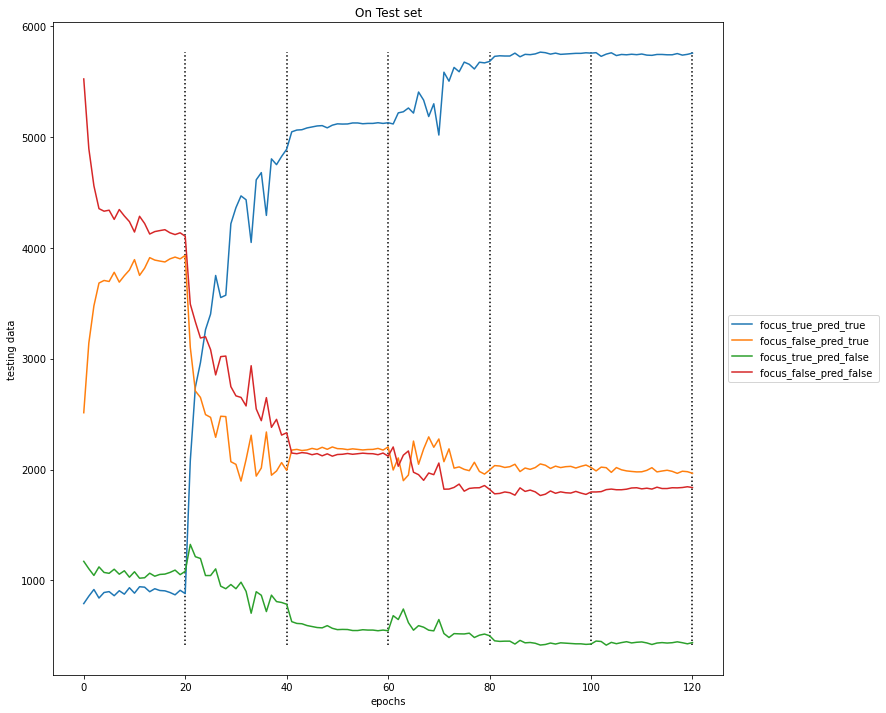

In [40]:
# plt.figure(figsize=(12,12))
# plt.plot(df_test[columns[0]],df_test[columns[1]], label='argmax > 0.5')
# plt.plot(df_test[columns[0]],df_test[columns[2]], label='argmax < 0.5')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("epochs")
# plt.ylabel("test data")
# plt.title("On Testing set")
# #plt.vlines(vline_list,min(min(df_test[columns[1]]),min(df_test[columns[2]])), max(max(df_test[columns[1]]),max(df_test[columns[2]])),linestyles='dotted')
# plt.show()

plt.figure(figsize=(12,12))
plt.plot(df_test[columns[0]],df_test[columns[3]], label ="focus_true_pred_true ")
plt.plot(df_test[columns[0]],df_test[columns[4]], label ="focus_false_pred_true ")
plt.plot(df_test[columns[0]],df_test[columns[5]], label ="focus_true_pred_false ")
plt.plot(df_test[columns[0]],df_test[columns[6]], label ="focus_false_pred_false ")
plt.title("On Test set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("testing data")
plt.vlines(vline_list,min(min(df_test[columns[3]]),min(df_test[columns[4]]),min(df_test[columns[5]]),min(df_test[columns[6]])), max(max(df_test[columns[3]]),max(df_test[columns[4]]),max(df_test[columns[5]]),max(df_test[columns[6]])),linestyles='dotted')
plt.show()
fig.savefig("test_analysis_every_20.pdf")
fig.savefig("test_analysis_every_20.png")